
# Federated Lab — Experiment Comparison

This notebook scans `runs/<exp>/<timestamp>/fl_log.csv` and builds visualizations for:
- Global accuracy per round (across experiments)
- Reward heatmaps (round × node) per experiment
- Balance trajectories per node per experiment
- Quick summary: final global accuracy vs. malicious fraction/strategy (if present)

> Note: This expects the project to have been run at least once so that `runs/` contains results.


In [8]:

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

BASE = Path.cwd().resolve().parent / "runs"
print("Looking for runs in:", BASE)

Looking for runs in: /Users/yuandouwang/Documents/projects/federated_lab/runs


In [9]:

def load_all_runs(runs_root: Path) -> pd.DataFrame:
    runs_root = runs_root if runs_root.name == "runs" else (runs_root / "runs")
    rows = []
    if not runs_root.exists():
        print("No runs folder found:", runs_root)
        return pd.DataFrame()
    for exp_dir in sorted(runs_root.glob("*")):
        if not exp_dir.is_dir():
            continue
        for ts_dir in sorted(exp_dir.glob("*")):
            csv_path = ts_dir / "fl_log.csv"
            if csv_path.exists():
                try:
                    df = pd.read_csv(csv_path)
                    df["exp"] = exp_dir.name
                    df["ts"] = ts_dir.name
                    rows.append(df)
                except Exception as e:
                    print("Failed to read", csv_path, e)
    if not rows:
        return pd.DataFrame()
    return pd.concat(rows, ignore_index=True)

df = load_all_runs(BASE)
print("Loaded rows:", len(df))
df.head(3)


Loaded rows: 700


/var/folders/7m/dxc0c5jn3wxgnmc8pyf_kg6myjqnh1/T/ipykernel_13803/3633201926.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(rows, ignore_index=True)


,round,global_acc,manifest_cid,node_id,node_samples,node_loss,node_acc,update_type,update_cid,metrics_cid,...,exp,ts,samples,loss,acc,model_update_cid,stake,reputation,malicious_detected,committee
0,0,0.8352,Qm00000022,0,7682.0,0.255215,0.933025,delta,Qm00000001,Qm00000002,...,benign,20250812-154032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0.8352,Qm00000022,1,6725.0,0.146466,0.958815,delta,Qm00000003,Qm00000004,...,benign,20250812-154032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0.8352,Qm00000022,2,1321.0,0.221069,0.944335,delta,Qm00000005,Qm00000006,...,benign,20250812-154032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


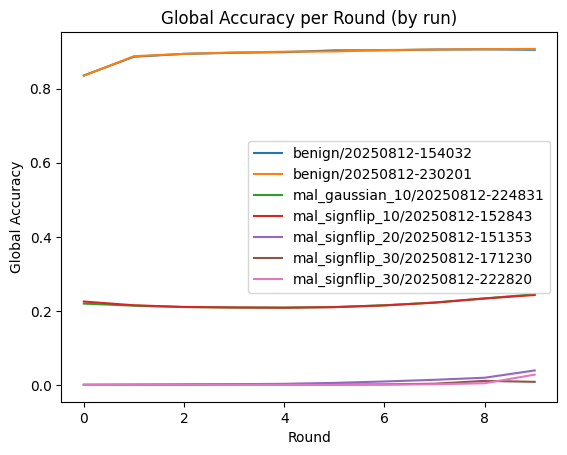

In [10]:

def plot_global_acc(df: pd.DataFrame, group_by_exp=True):
    if df.empty:
        print("No data")
        return
    # One figure, multiple lines is fine. No subplots, no custom colors.
    plt.figure()
    if group_by_exp:
        for (exp, ts), sub in df.groupby(["exp","ts"]):
            y = sub.groupby("round")["global_acc"].apply(lambda s: s.astype(str).str.replace('%','', regex=False)).astype(float)
            # global_acc was written as string; convert safely
            try:
                vals = pd.to_numeric(y, errors="coerce")
            except Exception:
                vals = y
            plt.plot(sorted(sub["round"].unique()), 
                     df[df["ts"]==ts].groupby("round").first()["global_acc"].astype(str).astype(float), 
                     label=f"{exp}/{ts}")
        plt.xlabel("Round"); plt.ylabel("Global Accuracy"); plt.title("Global Accuracy per Round (by run)")
        plt.legend()
    else:
        # aggregate across runs by exp
        for exp, sub in df.groupby("exp"):
            agg = sub.groupby("round")["global_acc"].apply(lambda x: pd.to_numeric(x.astype(str), errors="coerce")).mean()
            plt.plot(agg.index.values, agg.values, label=exp)
        plt.xlabel("Round"); plt.ylabel("Global Accuracy"); plt.title("Mean Global Accuracy per Round (by exp)")
        plt.legend()
    plt.show()

# clean conversion for global_acc column
def ensure_numeric_acc(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["global_acc"] = pd.to_numeric(out["global_acc"].astype(str), errors="coerce")
    return out

df = ensure_numeric_acc(df)
plot_global_acc(df, group_by_exp=True)


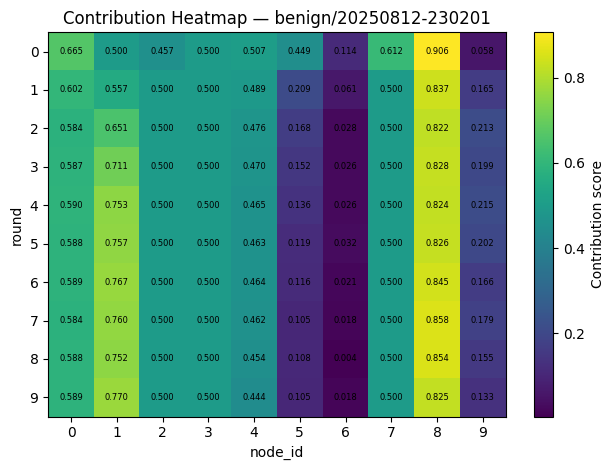

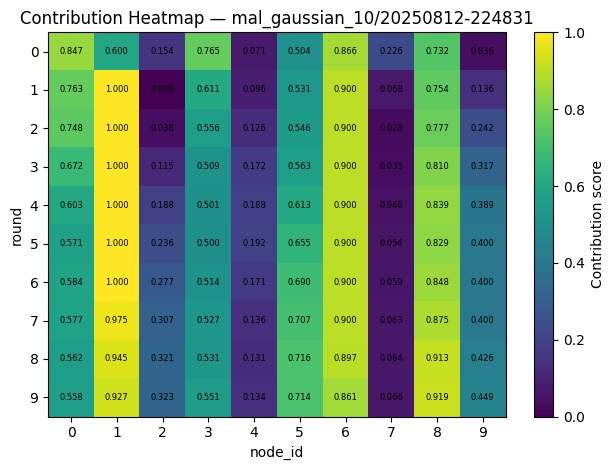

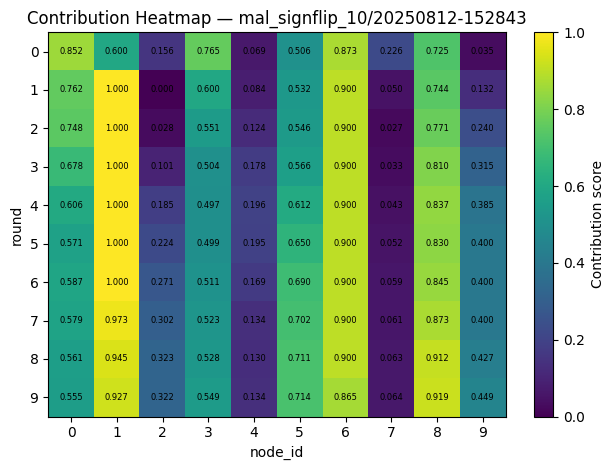

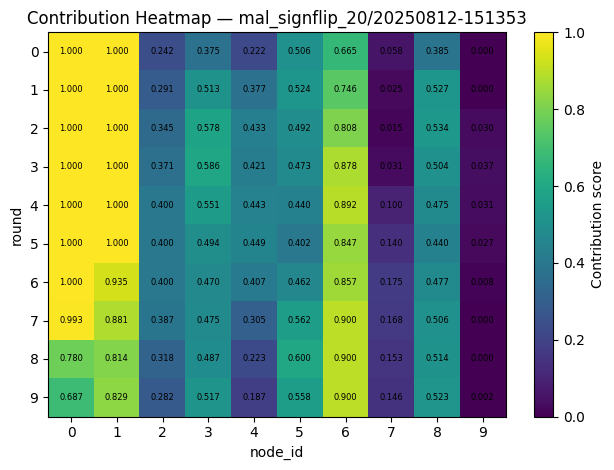

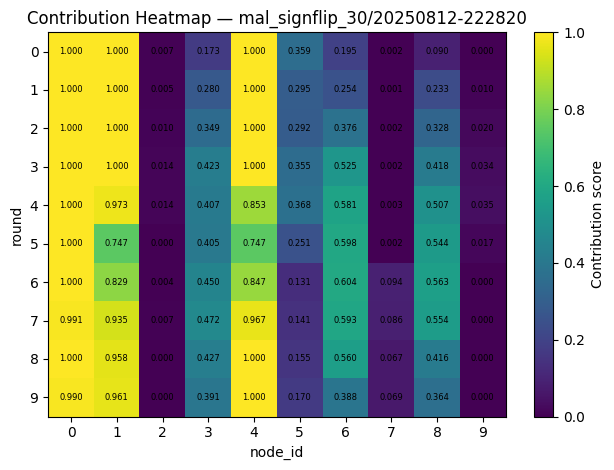

In [11]:
def contribution_heatmap(df: pd.DataFrame, exp: str, ts: str, value_col: str = "contrib_score"):
    sub = df[(df["exp"] == exp) & (df["ts"] == ts)].copy()
    if sub.empty:
        print("No data for", exp, ts)
        return

    # 确保数值列是数值型
    sub[value_col] = pd.to_numeric(sub[value_col], errors="coerce")

    # pivot: 行=round，列=node_id，值=贡献分
    piv = sub.pivot_table(index="round", columns="node_id", values=value_col, aggfunc="first").sort_index()
    mat = piv.values

    plt.figure()
    plt.imshow(mat, aspect="auto")  # 默认 colormap，不指定颜色
    cbar = plt.colorbar()
    cbar.set_label("Contribution score")

    plt.title(f"Contribution Heatmap — {exp}/{ts}")
    plt.xlabel("node_id")
    plt.ylabel("round")

    # 轴刻度
    plt.xticks(ticks=np.arange(piv.shape[1]), labels=piv.columns.tolist(), rotation=0)
    plt.yticks(ticks=np.arange(piv.shape[0]), labels=piv.index.tolist())

    # 小矩阵时在格子中写数字
    if mat.size <= 800:
        for i in range(mat.shape[0]):
            for j in range(mat.shape[1]):
                val = mat[i, j]
                if pd.notna(val):
                    plt.text(j, i, f"{val:.3f}", ha="center", va="center", fontsize=6)

    plt.tight_layout()
    plt.show()


# 选取“最新一次”运行并绘制贡献分热力图
if not df.empty:
    # ts 形如 YYYYMMDD-HHMMSS，字符串排序可代表时间先后
    # 为每个实验(exp)的最新一次(ts)绘制贡献分热力图
    for exp in df["exp"].unique():
        exp_df = df[df["exp"] == exp]
        # 找到该实验下最新的 ts
        latest_ts = exp_df["ts"].sort_values().iloc[-1]
        contribution_heatmap(df, exp, latest_ts)


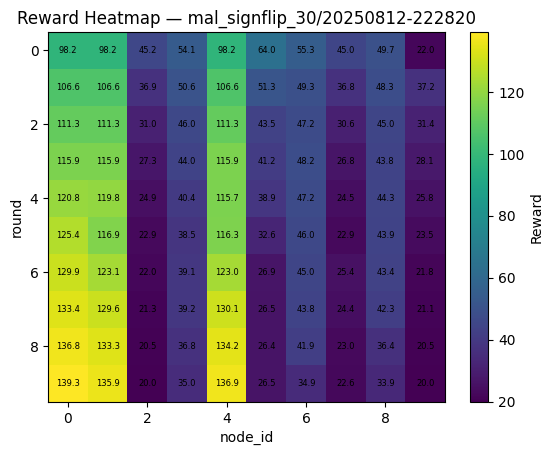

In [12]:

def reward_heatmap(df: pd.DataFrame, exp: str, ts: str):
    sub = df[(df["exp"]==exp) & (df["ts"]==ts)].copy()
    if sub.empty:
        print("No data for", exp, ts); return
    piv = sub.pivot_table(index="round", columns="node_id", values="reward", aggfunc="first")
    mat = piv.values
    plt.figure()
    plt.imshow(mat, aspect="auto")  # default colormap
    plt.colorbar(label="Reward")
    plt.title(f"Reward Heatmap — {exp}/{ts}")
    plt.xlabel("node_id")
    plt.ylabel("round")
    # show values on cells (avoid clutter for large mats)
    if mat.size <= 800:
        for i in range(mat.shape[0]):
            for j in range(mat.shape[1]):
                val = mat[i, j]
                if pd.notna(val):
                    plt.text(j, i, f"{val:.1f}", ha="center", va="center", fontsize=6)
    plt.show()

# pick the latest run
if not df.empty:
    last = df.groupby(["exp","ts"]).size().reset_index().sort_values(["exp","ts"]).iloc[-1]
    reward_heatmap(df, last["exp"], last["ts"])


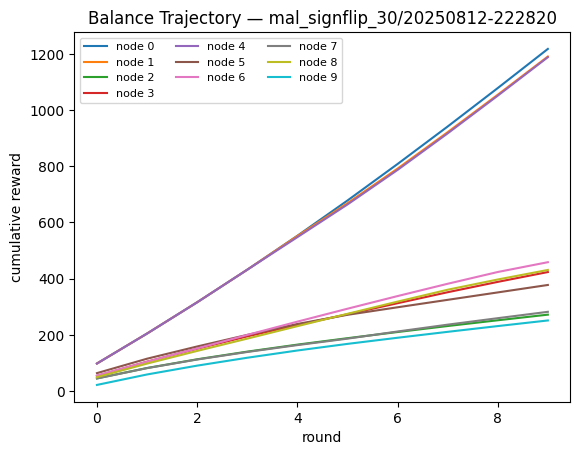

In [13]:

def plot_balances(df: pd.DataFrame, exp: str, ts: str):
    sub = df[(df["exp"]==exp) & (df["ts"]==ts)].copy()
    if sub.empty:
        print("No data for", exp, ts); return
    plt.figure()
    for nid, g in sub.groupby("node_id"):
        # cumulative balance already stored per row; but to be safe, compute cumulative from rewards
        g = g.sort_values("round")
        cum = g["reward"].fillna(0).cumsum()
        plt.plot(g["round"].values, cum.values, label=f"node {nid}")
    plt.title(f"Balance Trajectory — {exp}/{ts}")
    plt.xlabel("round"); plt.ylabel("cumulative reward")
    plt.legend(ncol=3, fontsize=8)
    plt.show()

if not df.empty:
    last = df.groupby(["exp","ts"]).size().reset_index().sort_values(["exp","ts"]).iloc[-1]
    plot_balances(df, last["exp"], last["ts"])


,exp,ts,final_acc
0,benign,20250812-154032,0.9046
1,benign,20250812-230201,0.9068
2,mal_gaussian_10,20250812-224831,0.2450
3,mal_signflip_10,20250812-152843,0.2432
4,mal_signflip_20,20250812-151353,0.0397
5,mal_signflip_30,20250812-171230,0.0090
6,mal_signflip_30,20250812-222820,0.0284


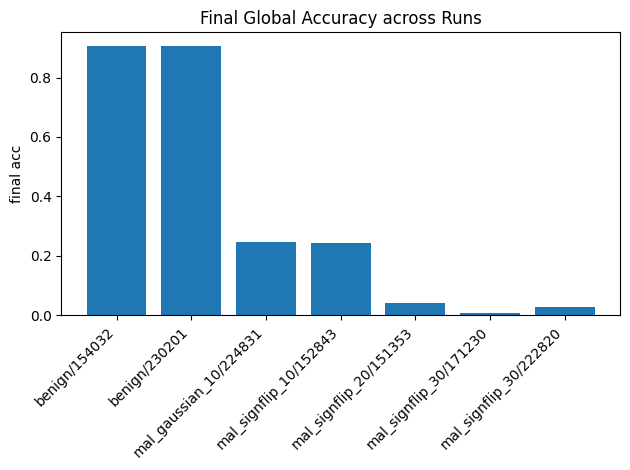

In [14]:

def summarize_final_acc(df: pd.DataFrame):
    if df.empty: 
        print("No data"); return
    # final acc per run is acc at max round for that (exp,ts)
    rows = []
    for (exp, ts), g in df.groupby(["exp","ts"]):
        max_r = g["round"].max()
        acc = pd.to_numeric(g[g["round"]==max_r]["global_acc"].astype(str), errors="coerce").mean()
        # Try parse malicious ratio/strategy from exp name if encoded (optional)
        rows.append({"exp": exp, "ts": ts, "final_acc": acc})
    out = pd.DataFrame(rows).sort_values(["exp","ts"])
    display(out)
    plt.figure()
    plt.bar(range(len(out)), out["final_acc"].values)
    plt.xticks(range(len(out)), [f"{e}/{t[-6:]}" for e,t in zip(out["exp"], out["ts"])], rotation=45, ha="right")
    plt.title("Final Global Accuracy across Runs")
    plt.ylabel("final acc")
    plt.tight_layout()
    plt.show()

summarize_final_acc(df)
